# Price Prediction

In this Python notebook I will demonstrate how to perform all datascience steps in order to better understand and infer the prices of residences in the United States.

First of all, let's read some basic libraries that will help us do the necessary work.

In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
sns.set()
plt.style.use('seaborn-talk')

Now that we have loaded some default python libraries for datascience, let's work upon the dataset analysis. To do this, let's first open the input file into a pandas dataframe named properties.

In [2]:
df_properties = pd.read_csv("properties.csv", sep=',')

Let's verify if the file was correctly loaded by showing up the amount of lines and columns for the file. Then let's verify how this dataset looks like by observing the set of features that compose each individual sample.

In [3]:
print("Lines: %s, columns: %s" % df_properties.shape)
df_properties.head(5)

Lines: 176081, columns: 8


,apn,zip_code,property_type,lot,sqft,beds,baths,price
0,06037-5782020007,91007,residential,20492.0,2991.0,4,2.5,2168000
1,06037-5436013020,90039,residential,6752.0,1533.0,3,2.0,898000
2,06037-2549013007,91040,residential,38757.0,3146.0,4,4.0,998999
3,06059-03318106,92831,residential,6375.0,1364.0,3,1.0,549000
4,06059-93279051,92637,residential,1700.0,1592.0,3,2.0,699999


As we can observe above, this dataset contains over 176 thousand samples. The set of features that describes the dataset are:
* apn: This feature is the property identifier.
* zip_code: This feature refers to the region of a given property.
* property_type: This feature indentifies the kind of property
* lot: This feature is the area of the lot
* sqft: This feature describes the square feet of the residence
* beds: This refers to the amount of beds in the apartment
* baths: This is basically the kinds of bathrooms. This value is the sum of individual bathrooms.
* price: This is the price for each individual apartment.

Now let's try to infer some statistics from this dataset.
As we can observe in the bellow code, the type of the property has three different versions: *residential*, *lease* and *residential income*.

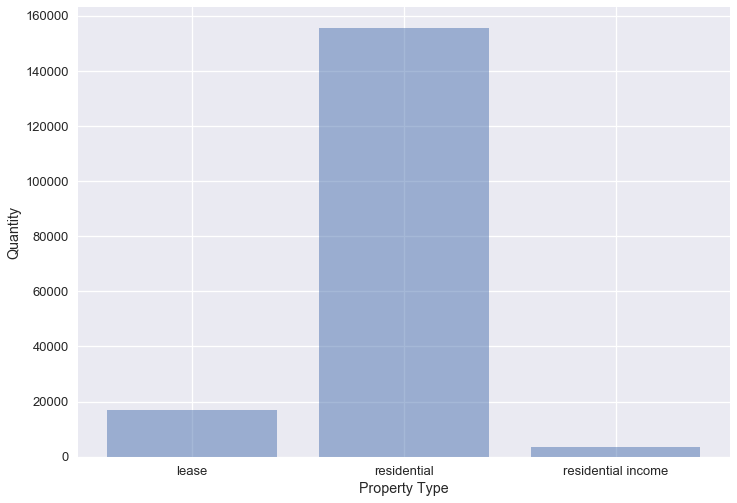

In [4]:
qt_prop_type_value = df_properties.groupby(by='property_type').count()['apn'].values
qt_prop_type_name = df_properties.groupby(by='property_type').count()['apn'].index.values
plt.bar(np.arange(3), qt_prop_type_value, alpha=0.5)
plt.xlabel("Property Type")
plt.ylabel("Quantity")
a = plt.xticks(np.arange(3), qt_prop_type_name)
plt.tight_layout()

As we can observe, most of the properties in these dataset belong to the residential type with over $155$ thousand properties.

Let's filter this dataset and work only with the set os samples belonging to the residential type. The code to filter these samples is shown bellow:

In [5]:
df_residences = df_properties[df_properties['property_type'] == 'residential']
print("New dataframe with %s lines and %s columns" % df_residences.shape)

New dataframe with 155421 lines and 8 columns


Now that we have filtered out the *residences* from the original dataset, let's verify if there are any samples with missing:


In [6]:
df_residences.isnull().any('index')

apn              False
zip_code         False
property_type    False
lot              False
sqft             False
beds             False
baths            False
price            False
dtype: bool

As we can verify, there is no missing values in this subset, so we can proceed with the statistical analysis of the data before dive into the construction of Machine Learning models.

Firstly, let's try to identify if there are more than one residence per area.
The first starting point is to just observe the behavior of the data with a box plot and observe the average amount of residences per area (zip_code). After that, let's build a histogram to identify the distribution of samples per area. Let's gather these insights in the following charts:

In [7]:
res_per_area = df_residences.groupby(by='zip_code', sort=False).count().sort_values(by='apn', ascending=False)

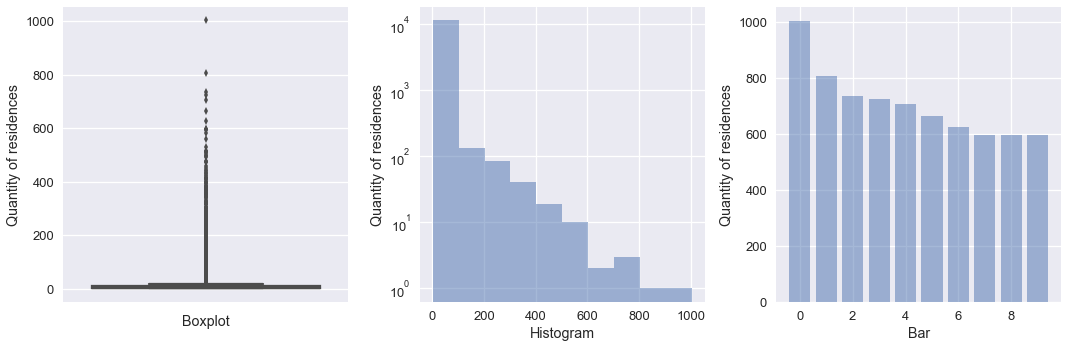

In [8]:
plt.rcParams["figure.figsize"] = (15, 5)
fig, ax = plt.subplots(nrows=1, ncols=3)
sns.boxplot(res_per_area['apn'], ax=ax[0], orient='vertical')
ax[1].hist(res_per_area['apn'], alpha=0.5, log=True)
ax[2].bar(np.arange(10), res_per_area['apn'].values[0:10], alpha=0.5)
ax[0].set_ylabel("Quantity of residences")
ax[1].set_ylabel("Quantity of residences")
ax[2].set_ylabel("Quantity of residences")
ax[0].set_xlabel("Boxplot")
ax[1].set_xlabel("Histogram")
ax[2].set_xlabel("Bar")
plt.tight_layout()

As we can observe above, the boxplot shows that almost the entire dataset has only a few residences per area and we can even consider that the few zip code areas with over 100 residences can be considered outliers under the box plot perspective. This same observation can be corroborated by looking at the histogram (log scale), which shows that most of the areas contains just a few residences (less than 100), and only a few of the zip code areas have over 100 residences. The last chart shows the amount of residences for the bigger areas.

In [9]:
df_residences.head(3)

,apn,zip_code,property_type,lot,sqft,beds,baths,price
0,06037-5782020007,91007,residential,20492.0,2991.0,4,2.5,2168000
1,06037-5436013020,90039,residential,6752.0,1533.0,3,2.0,898000
2,06037-2549013007,91040,residential,38757.0,3146.0,4,4.0,998999


As we noted in the previous analysis, the box plot is a great tool to identify the data distribution considering the interquantile ranges. Let's use this great tool one more time to grasp the behavior for the remaining variables. Let's start by observing the feature **beds** and **baths**:

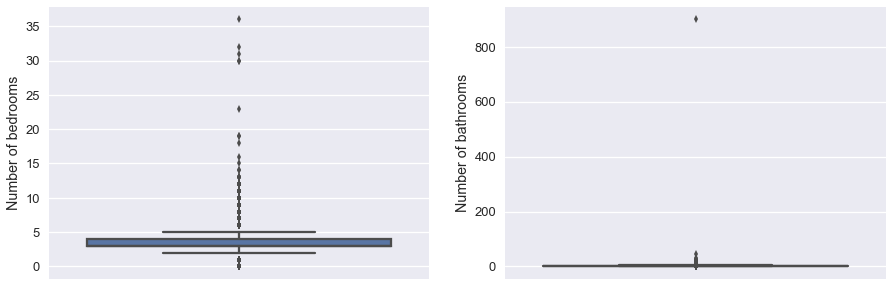

In [10]:
plt.rcParams["figure.figsize"] = (15, 5)
fig, ax = plt.subplots(nrows=1, ncols=2)
a = sns.boxplot(df_residences['beds'], ax=ax[0], orient='vertical')
a = sns.boxplot(df_residences['baths'], ax=ax[1], orient='vertical')
ax[0].set_ylabel("Number of bedrooms")
ax[1].set_ylabel("Number of bathrooms")

In [11]:
df_residences.query("beds > 30")

,apn,zip_code,property_type,lot,sqft,beds,baths,price
88066,12119-031924001000001500,34731,residential,0.19,1512.0,36,2.00,160700
131999,06071-0482223240000,92395,residential,7200.00,1572.0,32,2.00,235000
136737,06037-7317018155,90810,residential,4041.00,1500.0,31,1.75,299000


As we can observe, the boxplot on the left shows the distribution of beds per residence. As we may observe in this chart, the second and third quartile allows us to see that $\approx50\%$ of the residences contains $4$ bedrooms. The first quartile shows that $\approx25\%$ of the data contains $2$ bedrooms, while the fourth quartile allow us to see that the remaing $25\%$ percent of the data contains around $5$ bedrooms per residence. We can also visualize in this chart that there are a only few residences with none or with over $6$ bedrooms up to the maximum of $36$ bedrooms per residence.

The box plot in the right shows that most of the data seems to be flattened near zero with an outlier containing a huge number of bathrooms. By investigating this single residence a little deeper in the code bellow, we can observe that this residence has a lot of $0$, a squared feet area of $2004$, zero bedrooms, and 900 bathrooms with a price of 69900.

In [12]:
df_residences.query("baths > 100")

,apn,zip_code,property_type,lot,sqft,beds,baths,price
11763,12111-240880101320001,34947,residential,0.0,2004.0,0,900.0,69900


The boxplot bellow shows the amount of bathrooms per residence after removing the aforementioned outlier. As we can observe, the second and third quartile of the boxplot indicates that $\approx50\%$ of residences has around 2 and 3 bathrooms. The fourth quartile allows us to see that $\approx25\%$ of the residences contains between 4 and 5 bathrooms while the remaining $\approx25\%$ of the residences contains 1 bathroom. Its possible to see as weel that a few remaining residences contains over $5$ bathrooms up to the maximum of $45$ bathrooms. It's also possible to ponder that there are some few residences with zero bathrooms that can be considered outliers. We can use the knowledge of knowing these outliers to build more sofisticated models that take them into consideration. For example, by ackowleging they existence, we can build estimators that are able to keep focus in these hard regions of the input space (some boosting procedure) or simple ignoring these hard to predict regions removing these samples from the dataset.

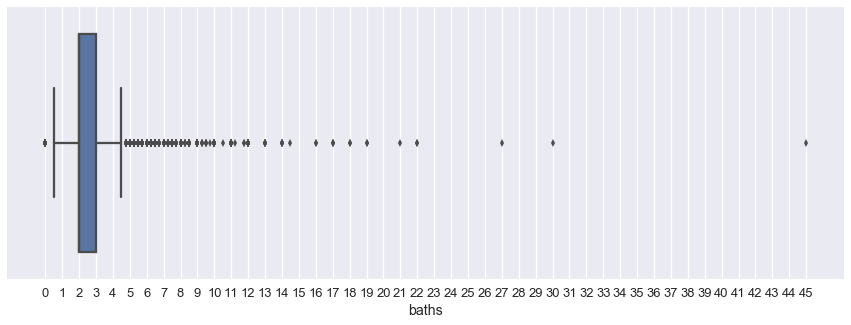

In [13]:
sns.boxplot(df_residences.query("baths <= 100")['baths'], orient='horizon')
a= plt.xticks(np.arange(0, 46, 1), np.arange(0, 46, 1))

Folowing up the analysis for the remaining features **lot**, **sqft**, and **price** we can note that the they do contains some few outliers samples in the dataset. As it's possible to observe in the box plot for the three variables bellow, all of them have a single sample (residence) that is very apart from the the remaining ones:

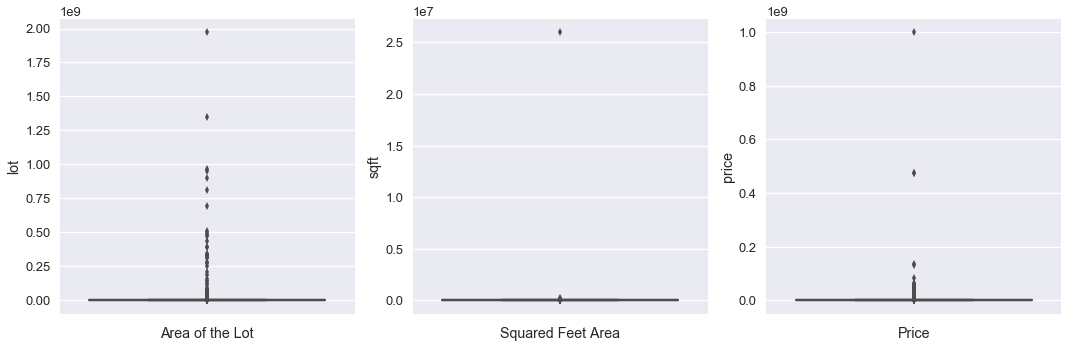

In [14]:
plt.rcParams['figure.figsize'] = (15, 5)
fig, ax = plt.subplots(nrows=1, ncols=3)
sns.boxplot(df_residences['lot'], ax=ax[0], orient='vertical')
sns.boxplot(df_residences['sqft'], ax=ax[1], orient='vertical')
sns.boxplot(df_residences['price'], ax=ax[2], orient='vertical')
ax[0].set_xlabel('Area of the Lot')
ax[1].set_xlabel('Squared Feet Area')
ax[2].set_xlabel('Price')
plt.tight_layout()

Since the **sqft** and **price** features have the most outstanding outlier (more apart from the reamining ones), let's identify them and replot the boxplot for these two features. The first 10 residences sorted by each feature is shown the the two following tables.

In [15]:
df_residences.sort_values(by='sqft', ascending=False)[0:10]

,apn,zip_code,property_type,lot,sqft,beds,baths,price
65879,29167-073208000000012000,65613,residential,5.86,26002700.0,3,3.0,159900
34529,13313-2733608040,30740,residential,1.18,231227.0,4,4.0,165000
65218,51680-10155400,24551,residential,0.73,153414.0,4,3.0,254900
67987,06071-0309221050000,92315,residential,92752.00,92752.0,14,14.0,1795000
64542,06071-0309221050000,92315,residential,0.00,92752.0,14,14.0,1825000
44844,39037-B0602140200003030,45348,residential,1.70,74052.0,2,2.0,140000
27772,45079-170820207,29223,residential,0.00,57828.0,2,2.0,35000
102209,06037-2327018032,91605,residential,79973.00,45020.0,1,1.0,190000
823,06079-013381025,93428,residential,1264111.00,37500.0,12,14.5,55000000
6610,13117-072123,30028-6931,residential,0.64,31180.0,4,4.0,399877


Let's try to identify if this residences are the same for all 5 variables:

In [16]:
df_residences.sort_values(by='price', ascending=False)[0:10]

,apn,zip_code,property_type,lot,sqft,beds,baths,price
99284,06037-8529012114,91010,residential,99999.00,100.0,30,45.00,999999000
90601,45063-00311601045,29054,residential,0.96,3322.0,5,4.00,475000000
95268,06073-4463610406,92104,residential,0.00,1209.0,3,2.00,474900000
114620,06079-033312003,93465,residential,3637260.00,0.0,9,7.50,135000000
52487,45079-042040204,29063,residential,0.00,1387.0,3,2.00,129900000
17554,06071-0473342060000,92307,residential,0.51,2700.0,4,4.00,82000075
53364,06073-06031116,92672,residential,237358.00,15000.0,9,11.75,63500000
83580,45079-1450117014000,29180,residential,0.25,1200.0,3,2.00,59950000
84354,06059-47309102,92657,residential,0.00,17000.0,8,17.00,55000000
823,06079-013381025,93428,residential,1264111.00,37500.0,12,14.50,55000000


# Building a model

## Feature Engeneering: One-hot encoding

In [17]:
df_residences.head(5)

,apn,zip_code,property_type,lot,sqft,beds,baths,price
0,06037-5782020007,91007,residential,20492.0,2991.0,4,2.5,2168000
1,06037-5436013020,90039,residential,6752.0,1533.0,3,2.0,898000
2,06037-2549013007,91040,residential,38757.0,3146.0,4,4.0,998999
3,06059-03318106,92831,residential,6375.0,1364.0,3,1.0,549000
4,06059-93279051,92637,residential,1700.0,1592.0,3,2.0,699999


In [18]:
X = df_residences.drop(['apn', 'property_type'], axis=1)

In [19]:
X.head(5)

,zip_code,lot,sqft,beds,baths,price
0,91007,20492.0,2991.0,4,2.5,2168000
1,90039,6752.0,1533.0,3,2.0,898000
2,91040,38757.0,3146.0,4,4.0,998999
3,92831,6375.0,1364.0,3,1.0,549000
4,92637,1700.0,1592.0,3,2.0,699999


In [20]:
X.shape

(155421, 6)

In [21]:
hot_encoding = pd.get_dummies(X['zip_code'])

In [22]:
hot_encoding.shape

(155421, 11566)

In [23]:
X = X.drop('zip_code', axis=1)

In [24]:
X = X.join(hot_encoding)

In [25]:
X.head(3)

,lot,sqft,beds,baths,price,02814,02886,06001,06010,06016,...,99212-0506,99216,99216-0309,99216-0939,99217,99218,99218-1054,99223,99224,99224-8568
0,20492.0,2991.0,4,2.5,2168000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6752.0,1533.0,3,2.0,898000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38757.0,3146.0,4,4.0,998999,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
y = X['price']

In [27]:
X = X.drop('price', axis=1)

## Model Validation: Holdout Sets

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

In [29]:
model0 = DecisionTreeRegressor(criterion='mse',
                               splitter='best',
                               max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_leaf_nodes=None)

In [30]:
model1 = RandomForestRegressor(n_estimators=100,
                               criterion='mse',
                               max_features="sqrt",
                               max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               bootstrap=True,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=1,
                               verbose=0)

In [31]:
model2 = ExtraTreesRegressor(n_estimators=100,
                             criterion='mse',
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             bootstrap=True,
                             oob_score=True,
                             n_jobs=-1,
                             random_state=1, 
                             verbose=False)

In [32]:
model3 = GradientBoostingRegressor(loss='ls',
                                   learning_rate=0.1,
                                   n_estimators=100,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   max_depth=3)

In [33]:
model0.fit(X=x_train, y=y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [34]:
model1.fit(X=x_train, y=y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [35]:
model2.fit(X=x_train, y=y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=-1, oob_score=True, random_state=1,
          verbose=False, warm_start=False)

In [36]:
result_model0 = model0.predict(x_test)
result_model1 = model1.predict(x_test)
result_model2 = model2.predict(x_test)

Let's use the Mean Absolute Percentage Error to identify how good the model is. Since the sklearn does not have this specific metric implemented, let's implement it according to the [Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) descritpion.

In [37]:
def weightedAbsolutePercentageError(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    absolute_diff = np.abs(y_true - y_pred)
    diff_sum = np.sum(absolute_diff)
    total_sum = np.sum(y_true)
    return diff_sum / total_sum

In [38]:
def meanAbsolutePercentageError(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    difference = y_true - y_pred
    absolute_diff = np.abs(difference / y_true)
    mean = np.mean(absolute_diff)
    return mean*100

In [39]:
print("Predictions Decision Tree %s" % (100*(1-weightedAbsolutePercentageError(y_test, result_model0))))
print("Predictions Random Forests %s" % (100*(1-weightedAbsolutePercentageError(y_test, result_model1))))
print("Predictions Extra Trees Regressor %s" % (100*(1-weightedAbsolutePercentageError(y_test, result_model2))))

Predictions Decision Tree 65.5266654021
Predictions Random Forests 74.3466934738
Predictions Extra Trees Regressor 76.107605734


## Model Validation: Cross Validation

In [40]:
result_cv_model0 = cross_val_predict(model0, X=X, y=y, cv=5)

In [41]:
result_cv_model1 = cross_val_predict(model1, X=X, y=y, cv=5)

In [42]:
result_cv_model2 = cross_val_predict(model2, X=X, y=y, cv=5)

In [43]:
print("Predictions Decision Tree %s" % (100*(1-weightedAbsolutePercentageError(y, result_cv_model0))))
print("Predictions Random Forests %s" % (100*(1-weightedAbsolutePercentageError(y, result_cv_model1))))
print("Predictions Extra Trees Regressor %s" % (100*(1-weightedAbsolutePercentageError(y, result_cv_model2))))

Predictions Decision Tree 60.2658657332
Predictions Random Forests 71.7938611092
Predictions Extra Trees Regressor 73.706041867
